In [ ]:
from queue import Queue
from csv import writer
class SqrVertex:                        #класс, описывающий вершину графа (маршрутизатор)

    def __init__(self, x: int, y: int, delays = [0, 0, 0, 0]):
        self.x = x                      #номер строки вершины
        self.y = y                      #номер столбца вершины
        self.delays = delays            #задержки по различным направлениям (веса ребер) в порядке: вверх, вниз, влево, вправо
        self.flag = 0                   #флаг, чтобы отмечать вершину как посещенную при обходе Дейкстрой
        self.distance = float('inf')    #расстояние от какой-то выбранной вершины до данной
        self.ways = []                  #массив с путями к другим вершинам
        self.parent = 0                 #предшествующая вершина (для поиска в ширину)

class SqrNet:                           #класс, описывающий квадратную сеть

    def __init__(self, N: int, delays: list):           #delays состоит из двух подмассивов - горизонтальные и вертикальные ребра. В каждом из подмассивов ребра занумерованы двумя индексами: строка+столбец (или столбец+строка)

        if len(delays) != 2 or len(delays[1]) != N or len(delays[0]) != N: #проверим, что размер массива задержек (весов ребер) имеет корректыные размеры.
            return "delay list size error"
        
        else:
            for i in range (N):
                if len(delays[0][i]) != N-1 or len(delays[1][i]) != N-1: #все еще проверяем размеры массива. По-хорошему еще бы положительность всех задержек проверять, иначе Дейкстра некорректен.
                  return "delay list size error"  
            self.delays = delays
            self.size = N
            self.vert_list = []         #это массив с вершинами
            for i in range (N):
                self.vert_list += [[]]
                for j in range (N):
                    self.vert_list[i] += [0]
                    self.vert_list[i][j] = SqrVertex(i, j, delays = [float('inf'), float('inf'), float('inf'), float('inf')]) #инициализация вершин, по умолчанию все задержки бесконечны (граф несвязен)
            
            for i in range (N):
                    for j in range (N-1):
                        self.vert_list[i][j].delays[3] = self.vert_list[i][j+1].delays[2] = delays[0][i][j] #здесь присваиваем задержки. Предполагается, что каналы симметричны (задержка из а в b равна задержке из b в а)
                        self.vert_list[j][i].delays[1] = self.vert_list[j+1][i].delays[0] = delays[1][i][j]
    

    def step(self, start: SqrVertex, direction: int):           #операция "шага" в определенном направлении (0 - вверх, 1 - вниз, 2 - влево, 3 - вправо)
        if direction == 0 and start.delays[0]<float('inf'):     #сделал, потому что показалось удобным, хотя, возможно, это неоптимально
            return self.vert_list[start.x - 1][start.y]         #
        elif direction == 1 and start.delays[1]<float('inf'):
            return self.vert_list[start.x + 1][start.y]
        elif direction == 2 and start.delays[2]<float('inf'):
            return self.vert_list[start.x][start.y - 1]
        elif direction == 3 and start.delays[3]<float('inf'):
            return self.vert_list[start.x][start.y+1]
                              

    def dijkstra (self, start_x: int, start_y: int):                                           #собственно, алгоритм Дейкстры
        if not((start_x<self.size and start_x > -1) and (start_y<self.size and start_y > -1)): #проверка корректности координат вершины, относительно которой вычисляются пути
            return "no vertex with such coordinates"
        else:
            for i in self.vert_list: 
                    for j in i:
                        j.distance = float('inf')                   #сбрасываем все distancы и flagи в бесконечность и ноль (они могли быть изменены предыдущим вызовом Дейкстры)
                        j.flag = 0
            start = self.vert_list[start_x][start_y]                #определение отправной вершины (расстояние до/от которой считаем)
            start.distance = 0
            start.ways = []
            for i in range (self.size):                             #формирование массива путей. Он организован как матрица, где ij-ой вершине соотвествует ij-ый массив из элементов {0, 1, 2, 3}, 
                start.ways += [[]]                                  #отражающих движение на каждом шаге {вверх, вниз, влево, вправо} соотвественно. Последним элементом массива пути до вершины будет его длина.
                for j in range (self.size):
                    start.ways[i] += [[]]
            next_vert = self.vert_list[start_x][start_y]            #"затравка" для начала первой итерации Дейкстры

            for k in range (self.size**2):                          #обходим все вершины
                for i in self.vert_list:
                    for j in i:
                        if j.flag == 0:
                            if j.distance < next_vert.distance:
                                next_vert = j                       #выбор еще не посещенной вершины с минимальным расстоянием до стартовой
                
                for i in range (4):                                 #обходим все непосещенные соседние вершины                  
                    if type(self.step(next_vert, i)) == SqrVertex:  #step может ничего не вернуть (например, если шаг был сделан за пределы графа). Отфильтруем содержательные случаи
                        if self.step(next_vert, i).distance > next_vert.distance + next_vert.delays[i] and self.step(next_vert, i).flag == 0: #проверка, оказался ли данный путь короче уже существующих
                            next_vert_1 = self.step(next_vert, i)
                            next_vert_1.distance = next_vert.distance + next_vert.delays[i] #присваивание вершине нового (меньшего) расстояния 
                            start.ways[next_vert_1.x][next_vert_1.y] = start.ways[next_vert.x][next_vert.y] + [i] #корректеровка кратчайшего пути до вершины
                next_vert.flag = 1                                  #поднятие флага о посещении вершины
                start.ways[next_vert.x][next_vert.y].append(next_vert.distance) #путь до посещенной вершины больше не будет меняться, поэтому в конце добавим его длину, чтобы освободить distance для дальнейших выполнений алгоритма
                next_vert = next_vert_1                             #переопределение потенциально следующей вершины                                               
                   
                
            writer(open('dijkstra_ways.csv', 'w', newline ='')).writerows(start.ways)

    def BFS(self, start_x, start_y): #поиск в ширину
        if not((start_x<self.size and start_x > -1) and (start_y<self.size and start_y > -1)): #проверка корректности координат вершины, относительно которой вычисляются пути
                return "no vertex with such coordinates"
        else:
            for i in self.vert_list: 
                    for j in i:
                        j.distance = float('inf')                   #сбрасываем все distancы и flagи в бесконечность (они могли быть изменены предыдущим вызовом Дейкстры)
                        j.flag = 0                                  #вместо окраски вершин присваиваются значения flag = {0, 1, 2} для непосещенной, посещенной с непосещенными соседями и посещенной с посещенными соседями соотвественно
                        j.parent = None 
                    
            start = self.vert_list[start_x][start_y]                #определение отправной вершины (расстояние до/от которой считаем)
            start.distance = 0
            start.flag = 1
            start.ways = []
            for i in range (self.size):                             #формирование массива путей. Он организован как матрица, где ij-ой вершине соотвествует ij-ый массив из элементов {0, 1, 2, 3}  
                start.ways += [[]]                                  #отражающих движение на каждом шаге {вверх, вниз, влево, вправо} соотвественно. Последним элементом массива пути до вершины будет его длина.
                for j in range (self.size):
                    start.ways[i] += [[]]
            Q = Queue()
            Q.put(start)
            #подготовка к выполнению алгоритма завершена, далее основной цикл
            while not(Q.empty()):
                current_vert = Q.get()                          #выбираем вершину, у которой еще не все соседи посещены
                for i in range(4):                              #проходимся по соседям
                    next_vert = self.step(current_vert, i)      #чтобы не вызывать функцию step несколько раз
                    if type(next_vert) == SqrVertex:            #проверка существования вершины графа в i-ом направлении
                        if next_vert.flag == 0:                 #проверка непосещенности этой вершины
                            next_vert.flag = 1                  #отметим как посещенную (но еще не как вершину, все соседи которой - посещенные)
                            next_vert.distance = current_vert.distance + 1 #посчитаем расстояние в смысле числа ребер (поиск в ширь в квадратной топологии графа по сути бессмысленен: количество ребер между двумя вершинами определяется без всяких алгоритмов с помощью манхеттенской метрики)                            next_vert.parent = current_vert
                            start.ways[next_vert.x][next_vert.y] = start.ways[current_vert.x][current_vert.y] + [i]  #сохранение пути с указанным числом ребер
                            Q.put(next_vert)                    #добавим вновьпосещенную вершину в очередь
                current_vert.flag = 2                           #запишем, что все соседи посещены
                start.ways[current_vert.x][current_vert.y] = start.ways[current_vert.x][current_vert.y] + [current_vert.distance]#добавим к пути до только что обработанной вершины последний элемент - его длину в смысле количества ребер


    def DFS(self, start_x, start_y): #поиск вглубь
        if not((start_x<self.size and start_x > -1) and (start_y<self.size and start_y > -1)): #проверка корректности координат вершины, относительно которой вычисляются пути
                return "no vertex with such coordinates"
        else:
            for i in self.vert_list: 
                    for j in i:
                        j.distance = float('inf')       #сбрасываем все distancы и flagи в бесконечность (они могли быть изменены предыдущим вызовом Дейкстры)
                        j.flag = 0                      #вместо окраски вершин присваиваются значения flag = {0, 1, 2} для непосещенной, посещенной с непосещенными соседями и посещенной с посещенными соседями соотвественно
                        j.parent = None 
                    
            start = self.vert_list[start_x][start_y]    #определение отправной вершины (расстояние до/от которой считаем)
            start.distance = 0
            start.flag = 1
            start.ways = []
            for i in range (self.size):                 #формирование массива путей. Он организован как матрица, где ij-ой вершине соотвествует ij-ый массив из элементов {0, 1, 2, 3}  
                start.ways += [[]]                      #отражающих движение на каждом шаге {вверх, вниз, влево, вправо} соотвественно. Последним элементом массива пути до вершины будет его длина.
                for j in range (self.size):
                    start.ways[i] += [[]]
            def DFS_visit(vert: SqrVertex):             #определение функции посещения вершины
                vert.flag = 1                           #зафиксировали, что мы начинали обрабатывать эту вершину (ушли через нее "вглубь")
                try:
                    vert.distance = vert.parent.distance + vert.parent.delays[start.ways[vert.x][vert.y][-1]]#определение длины пути до обрабатываемой вершины (в смысле итоговой задержки)
                except AttributeError:                  #обработка ошибки, возникающей при попытке обратиться к предку стартовой вершины
                    pass
                for i in range(4):                      #обход всех соседей обрабатываемой вершины
                    next_vert = self.step(vert, i)      #чтобы не вызывать функцию step несколько раз
                    if type(next_vert) == SqrVertex:    #проверка существования вершины в данном направлении
                        if next_vert.flag == 0:         #проверка непосещенности данной вершины
                            next_vert.parent = vert     #определение родителя следующей вершины как обрабатываемой вершины 
                            start.ways[next_vert.x][next_vert.y] = start.ways[vert.x][vert.y] + [i]#добавление следующего звена в массив пути
                            DFS_visit(next_vert)        #рекурсивный переход к обработке следующей вершины
                vert.flag = 2                           #зафиксировали, что снова вернулись в вершину (считаем всю ветку за ней посещенной)
                start.ways[vert.x][vert.y] = start.ways[vert.x][vert.y] + [vert.distance]#добавление длины (в смысле итоговой задержки - суммы весов ребер) пути
                
        

            DFS_visit(start)                            #вызов функции обхода. Для квадратного графа достаточно вызвать функцию на одной вершине - стартовой  
            





            
                    

        


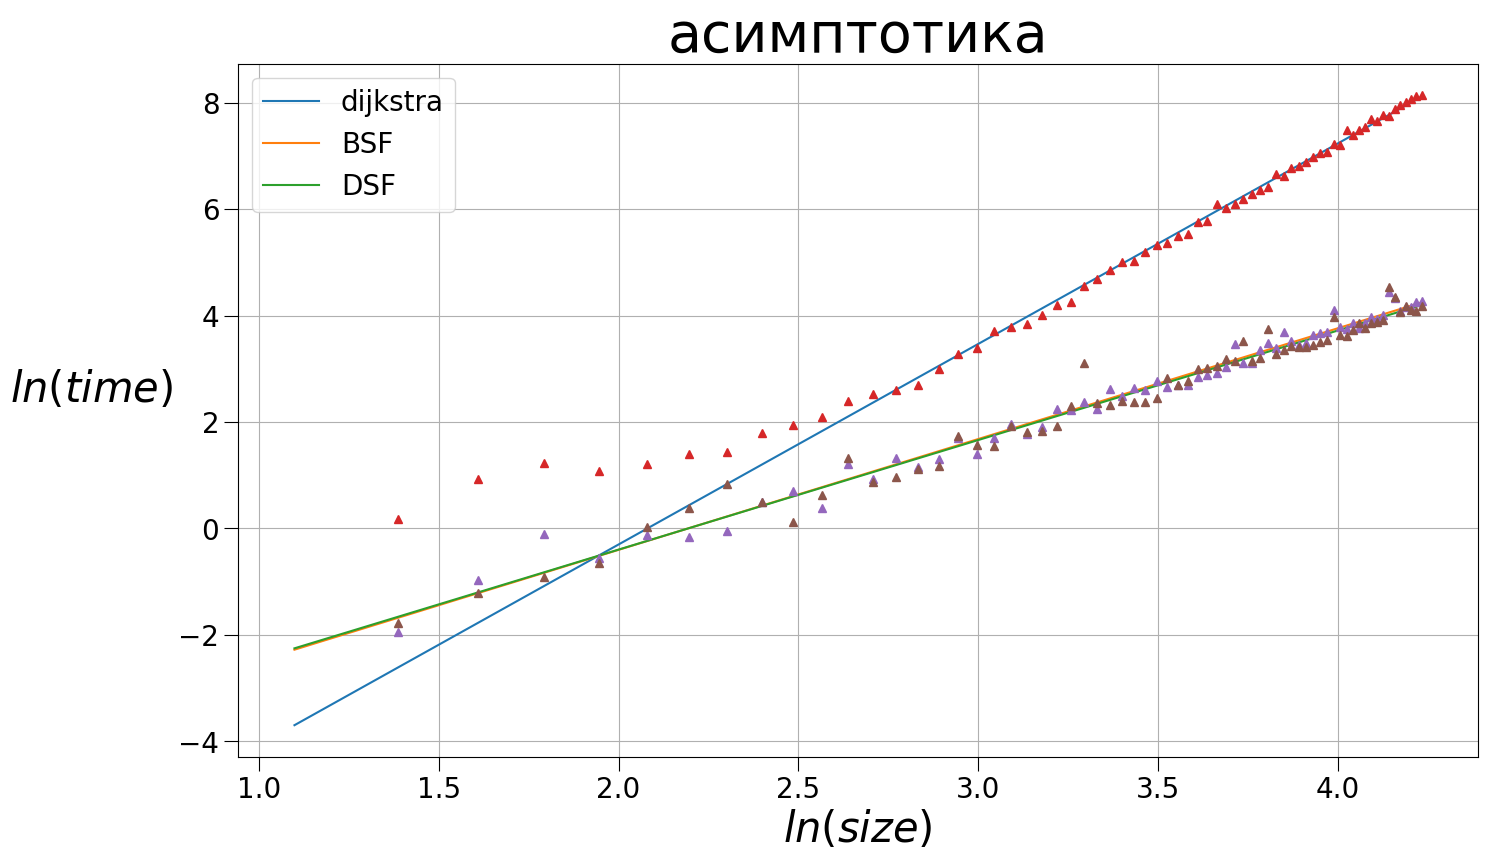

3.767137148139867
2.0814461303307215
2.0579837173041486


In [ ]:
import timeit
from random import randint
import csv
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


time_data = [['N', 'dijkstra time, ms', 'BSF time, ms', 'DSF time, ms']]
size = []
dtime = []
btime = []
dsftime = []
for N in range (3, 70):
    
    delays = [[],[]]
    for i in range (N):
        delays[0] += [[]]
        delays[1] += [[]]
        for j in range (N-1):
            delays[0][i] += [randint(2, 10)]
            delays[1][i] += [randint(2, 10)]
    td = timeit.timeit(lambda: net3.dijkstra(2,2), number=5)*200
    tb = timeit.timeit(lambda: net3.BFS(2,2), number=5)*200
    tdsf = timeit.timeit(lambda: net3.BFS(2,2), number=5)*200
    net3 = SqrNet(N, delays)
    time_data += [[N, td, tb, tdsf]]
    size += [np.log(N)]
    dtime += [np.log(td)]
    btime += [np.log(tb)]
    dsftime += [np.log(tdsf)]




csv.writer(open('time_data.csv', 'w', newline ='')).writerows(time_data)




z = np.polyfit(size[1:], btime[1:], deg = 1)
y = np.poly1d(z)

z1 = np.polyfit(size[10:], dtime[10:], deg = 1)
y1 = np.poly1d(z1)
z2 = np.polyfit(size[1:], dsftime[1:], deg = 1)
y2 = np.poly1d(z2)


fig, ax = plt.subplots(figsize=(16,9))
plt.title("асимптотика", fontsize = 40)
ax.plot(size, y1(size), label = 'dijkstra')
ax.plot(size, y(size), label = 'BSF')
ax.plot(size, y2(size), label = 'DSF')
ax.errorbar(size[1:], dtime[1:], fmt='^')
ax.errorbar(size[1:], btime[1:], fmt='^')
ax.errorbar(size[1:], dsftime[1:], fmt='^')
ax.grid()
ax.legend()
plt.legend(fontsize = 20)
plt.xlabel('$ln(size)$', fontsize = 30)
plt.ylabel("$ln(time)$", rotation=0, horizontalalignment='right',fontsize = 30)
plt.tick_params('both', size = 10, labelsize = 20)
plt.show()

#df = pd.read_csv('time_data.csv')
print(z1[0])
print(z[0])
print(z2[0])

Выводы.

Реализован класс графа топологии квадратной решетки размера N, где N - параметр. Для него реализованы расчеты длин путей во все вершины из выбранной с помощью алгоритмов Дейкстры, поиска в ширину и поиска в глубину. Реализовал с помощью некоторого гибрида списка смежности и матрицы смежности, просто потому что показалось прикольным.

Дейкстра.

Реализация самая простая, ее ожидаемая сложность $n^4$. Алгоритм записывает кратчайшие пути и их длины в csv файл. Прямо измеренная (на размерах графа от 3 до 70) сложность окзаталась чуть меньше - $n^3.77$. Это может быть связано с влиянием измерений с малым n (на графике хорошо видно, что начальные точки выбиваются из общей зависимости). Дейкстра дает заведомо верные результаты (в плане длины кратчайших путей).

Поиск в ширину.

Ожидаемая сложность алгоритма - $n^2$. С хорошей точностью она совпала с прямыми измерениями ($n^2.08$). Однако, данный алгоритм находит кратчайший путь в смысле числа ребер. Он будет предпочтительнее алгоритма Дейкстры при следующих условиях:
1.Достаточно большой размер графа (выигрыш в сложности)
2.Разница между весами ребер много меньше самих весов (минимальность расстояния в смысле суммарной задержки и в смылсе количества ребер практически эквивалентны)

Поиск в глубину.

Я, если честно, не понял, как с помощью поиска в глубину определять кратчайшие пути, так как он предназначен чисто для обхода вершин графа. Хотя определенные им пути далеки от кратчайших, рассчетная сложность алгоритма совпала с измеренной ($n^2$)

